# OpenAI sentiment for the headlines

1. Using the category probabilties from the classifier(stored in predictions.json) we will create appropriate prediction sets based on categories whose prediction probabilities exceed a given threshold value(one for broad categories one for society categories). This process allows us to dynamically categorize headlines and accurately assign them to one or more categories based on their prediction scores.
2. After obtaining the prediction sets we will use them to prompt OpenAI to give sentiment of the headlines in relation to the categories in the prediction set. This will give us sentiments that take context into account.


**NOTE:**
1. Due to large size of the dataset, the prompts for the dataset were implemneted in batches of size 2000. For first 4 batches(3 size 2000 and 1 of size 1000) the implementation ran for short amount of time(around 20mins), but for remaining it tool hours of time(and runtime gets disconnected) so implemented it in chunks and finally stored in 5 datasets.
  1. sentiment_results_0_2000.csv (0-2000)
  2. sentiment_results_2_2000.csv (2000-4000)
  3. sentiment_results_3_2000.csv (4000-6000)
  4. sentiment_results_4_1000.csv (6000-7000)
  5. sentiment_results_5_1000.csv (7000-8000)
  6. sentiment_results_6_1000.csv (8000-9000)
  7. sentiment_results_7_1000.csv (9000-10000)

##Importing and preparing data

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import json


import re
import nltk
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import json
# Load JSON
df = pd.read_json("datasets/predictions_with_sets.json", orient="records", lines=True)
df.head()

Unnamed: 0.1  Unnamed: 0       date  \
0             0           0 2024-10-14   
1             1           1 2024-02-21   
2             2           2 2024-02-05   
3             3           3 2024-08-28   
4             4           4 2024-10-15   

                                               title  \
0  will.i.am and Fyilicia on the AI revolution, i...   
1  Intel Launches World’s First Systems Foundry D...   
2     The Unique Challenges of Selling Enterprise AI   
3  Contentious California AI bill passes legislat...   
4  Exploring Genius, Creation, and Humanity in th...   

                                           source  number_of_characters_title  \
0                                Evening Standard                         122   
1  Investor Relations :: Intel Corporation (INTC)                         117   
2                                          Emerge                          54   
3                                         Reuters                          88   
4                          University of Aberdeen                          82   

   number_of_words_title day_of_week     month  year  quarter  is_weekend  \
0                     20      Monday   October  2024        4       False   
1                     18   Wednesday  February  2024        1       False   
2                      9      Monday  February  2024        1       False   
3                     11   Wednesday    August  2024        3       False   
4                     14     Tuesday   October  2024        4       False   

  category                                             title1  Topic  \
0    Other  will i am and fyilicia on the ai revolution   ...     72   
1    Other  intel launches world   s first systems foundry...     -1   
2   Career     the unique challenges of selling enterprise ai     11   
3    Other  contentious california ai bill passes legislat...     27   
4    Other  exploring genius   creation   and humanity in ...     -1   

                                         broad_probs  \
0  [0.055497236500000005, 0.0721101314, 0.1323647...   
1  [0.0665645674, 0.0402723849, 0.997704684700000...   
2  [0.087213859, 0.053182430600000004, 0.99415391...   
3  [0.1010741517, 0.0269009173, 0.993702411700000...   
4  [0.10324979570000001, 0.2586841881, 0.88165944...   

                                       society_probs  \
0  [0.1097167954, 0.3964278698, 0.105517827000000...   
1  [0.0255274419, 0.11106526850000001, 0.06824472...   
2  [0.0335974619, 0.0443848409, 0.269519180100000...   
3  [0.0425859392, 0.9999988079000001, 0.096546560...   
4  [0.0481622331, 0.0698647201, 0.1426308155, 0.0...   

                                      prediction_set  \
0                                          [{Other}]   
1                  [{AI in companies & Enterprises}]   
2  [{AI in various Industries}, {AI in companies ...   
3                    [{AI Governance & Geopolitics}]   
4                    [{AI overview, risks & impact}]   

                  probabilities  
0          [0.9999980927000001]  
1                [0.9976122975]  
2  [0.9593106508, 0.9491813779]  
3                [0.9937012196]  
4                [0.8816434741]

In [ ]:
def combine_and_filter_predictions(broad_probs, society_probs, broad_categories, society_categories, broad_threshold=0.3, society_threshold=0.6):
    # Filter broad categories based on probability threshold
    broad_pred_set = [(broad_categories[i], broad_probs[i]) for i in range(len(broad_probs)) if broad_probs[i] > broad_threshold]

    # Filter society categories based on probability threshold (only if broad category is "Society")
    society_pred_set = []
    if "{Society}" in [pred[0] for pred in broad_pred_set]:
        society_pred_set = [(society_categories[i], society_probs[i]) for i in range(len(society_probs)) if society_probs[i] > society_threshold]

    # Combine broad_pred_set and society_pred_set, replacing "Society" with specific society categories
    combined_pred_set = []
    combined_probs = []

    for category, prob in broad_pred_set:
        if category == "{Society}":
            # Replace "Society" with the specific society categories
            for society_category, society_prob in society_pred_set:
                combined_pred_set.append(society_category)
                combined_probs.append(society_prob)
        else:
            # Keep broad category
            combined_pred_set.append(category)
            combined_probs.append(prob)

    # Sort by probabilities in descending order
    sorted_indices = sorted(range(len(combined_probs)), key=lambda k: combined_probs[k], reverse=True)
    sorted_combined_pred_set = [combined_pred_set[i] for i in sorted_indices]
    sorted_combined_probs = [combined_probs[i] for i in sorted_indices]

    return sorted_combined_pred_set, sorted_combined_probs

In [ ]:
broad_categories = ['{Education}', '{Careers & Workforce}', '{Society}', '{Other}']
society_categories = ['{AI in various Industries}', '{AI in companies & Enterprises}',
       '{AI Investments & Market Trends}', '{AI Ethics, Law & Policy}',
       '{AI Governance & Geopolitics}', '{AI overview, risks & impact}']

In [ ]:
# Apply the function directly on the dataframe
df[['pred_set', 'pred_probs']] = df.apply(
    lambda row: pd.Series(combine_and_filter_predictions(
        row['broad_probs'],
        row['society_probs'],
        broad_categories,
        society_categories,
        broad_threshold=0.3,
        society_threshold=0.5
    )),
    axis=1
)

In [ ]:
df['prediction_set'].apply(lambda x: len(x)).value_counts()

prediction_set
1    7786
2    1971
3     225
0      13
4       5
Name: count, dtype: int64

## Implementing openAI prompting

In [ ]:
import pandas as pd
from tqdm import tqdm
from openai import OpenAI
tqdm.pandas()
# Initialize OpenAI client
client = OpenAI(api_key="Enter your openAI key")

# Define the prompt template

prompt_template = """Analyze the sentiment of the following news headline and classify it as Positive, Negative, or Neutral, considering the listed categories.

Headline: "{headline}" , Categories: {categories}

Instructions:
1.Focus on the sentiment in the context of the given categories.
2.Provide only one sentiment label: Positive, Negative, or Neutral.
3.Respond with just the sentiment label—no explanation needed."
"""

# Function to call OpenAI API
def openAI(prompt):
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        store=True,
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    return completion.choices[0].message.content.strip()  # Strip to remove extra spaces

# Function to get sentiment for a single headline
def get_sentiment(row):
    headline = row["title"]
    categories = ", ".join(row["prediction_set"])
    formatted_prompt = prompt_template.format(headline=headline,categories=categories )

    try:
        return openAI(formatted_prompt)
    except Exception as e:
        print(f"Error processing headline: {headline} - {e}")
        return "Error"


In [ ]:
headline = df['title'].iloc[2]
categories = ', '.join(list(df["prediction_set"].iloc[2]))
s = prompt_template.format(headline=headline,categories=categories )
s

'Analyze the sentiment of the following news headline and classify it as Positive, Negative, or Neutral, considering the listed categories.\n\nHeadline: "The Unique Challenges of Selling Enterprise AI" , Categories: {AI in various Industries}, {AI in companies & Enterprises}\n\nInstructions:\n1.Focus on the sentiment in the context of the given categories.\n2.Provide only one sentiment label: Positive, Negative, or Neutral.\n3.Respond with just the sentiment label—no explanation needed."\n'

In [ ]:
# Define batch size 0-2k
batch_size = 2000

# First batch (0-1999)
batch_1 = df.iloc[0:batch_size].copy()
batch_1["openAI_sentiment"] = batch_1.progress_apply(get_sentiment, axis=1)
# Save results for batch 1
batch_1.to_csv("datasets/sentiment_results_0_2000.csv", index=False)

100%|██████████| 2000/2000 [13:13<00:00,  2.52it/s]


In [ ]:
# 2nd batch (2k-4k)
batch_2 = df.iloc[2000:4000].copy()
batch_2["openAI_sentiment"] = batch_2.progress_apply(get_sentiment, axis=1)
# Save results for batch 2
batch_2.to_csv("datasets/sentiment_results_2_2000.csv", index=False)

100%|██████████| 2000/2000 [12:40<00:00,  2.63it/s]


In [ ]:
# 3rd batch (4k-6k)
batch_3 = df.iloc[4000:6000].copy()
batch_3["openAI_sentiment"] = batch_3.progress_apply(get_sentiment, axis=1)
# Save results for batch 3
batch_3.to_csv("datasets/sentiment_results_3_2000.csv", index=False)

100%|██████████| 2000/2000 [12:49<00:00,  2.60it/s]


In [ ]:
# 4th batch (6k-7k)
batch_4 = df.iloc[6000:7000].copy()
batch_4["openAI_sentiment"] = batch_4.progress_apply(get_sentiment, axis=1)
# Save results for batch 4
batch_4.to_csv("datasets/sentiment_results_4_1000.csv", index=False)

100%|██████████| 1000/1000 [06:13<00:00,  2.68it/s]


In [ ]:
# 4th batch (6k-7k)
batch_5 = df.iloc[7000:8000].copy()
batch_5["openAI_sentiment"] = batch_5.progress_apply(get_sentiment, axis=1)
# Save results for batch 4
batch_5.to_csv("datasets/sentiment_results_5_1000.csv", index=False)

100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s]


In [ ]:
# 4th batch (6k-7k)
batch_6 = df.iloc[8000:9000].copy()
batch_6["openAI_sentiment"] = batch_6.progress_apply(get_sentiment, axis=1)
# Save results for batch 4
batch_6.to_csv("datasets/sentiment_results_6_1000.csv", index=False)

100%|██████████| 1000/1000 [06:38<00:00,  2.51it/s]


In [ ]:
# 4th batch (6k-7k)
batch_7 = df.iloc[9000:10000].copy()
batch_7["openAI_sentiment"] = batch_7.progress_apply(get_sentiment, axis=1)
# Save results for batch 4
batch_7.to_csv("datasets/sentiment_results_7_1000.csv", index=False)

100%|██████████| 1000/1000 [1:55:07<00:00,  6.91s/it]


In [ ]:
df1 = pd.read_csv("datasets/sentiment_results_0_2000-2.csv")
df1.head(2)

Unnamed: 0.1  Unnamed: 0        date  \
0             0           0  2024-10-14   
1             1           1  2024-02-21   

                                               title  \
0  will.i.am and Fyilicia on the AI revolution, i...   
1  Intel Launches World’s First Systems Foundry D...   

                                           source  number_of_characters_title  \
0                                Evening Standard                         122   
1  Investor Relations :: Intel Corporation (INTC)                         117   

   number_of_words_title day_of_week     month  year  quarter  is_weekend  \
0                     20      Monday   October  2024        4       False   
1                     18   Wednesday  February  2024        1       False   

  category                                             title1  Topic  \
0    Other  will i am and fyilicia on the ai revolution   ...     72   
1    Other  intel launches world   s first systems foundry...     -1   

                                         broad_probs  \
0  [0.055497236500000005, 0.0721101314, 0.1323647...   
1  [0.0665645674, 0.0402723849, 0.997704684700000...   

                                       society_probs  \
0  [0.1097167954, 0.3964278698, 0.105517827000000...   
1  [0.0255274419, 0.11106526850000001, 0.06824472...   

                        prediction_set         probabilities openAI_sentiment  
0                          ['{Other}']  [0.9999980927000001]          Neutral  
1  ['{AI in companies & Enterprises}']        [0.9976122975]         Positive

In [ ]:
df2 = pd.read_csv("datasets/sentiment_results_2_2000-2.csv")
df2.head(2)

Unnamed: 0.1  Unnamed: 0        date  \
0          2000        2000  2024-03-31   
1          2001        2001  2024-01-17   

                                      title         source  \
0          10 AI Stocks That Will Skyrocket  Yahoo Finance   
1  Four Ways AI Has Already Changed Science     Techopedia   

   number_of_characters_title  number_of_words_title day_of_week    month  \
0                          48                      9      Sunday    March   
1                          53                      9   Wednesday  January   

   year  quarter  is_weekend category  \
0  2024        1        True    Other   
1  2024        1       False    Other   

                                     title1  Topic  \
0             ai stocks that will skyrocket      6   
1  four ways ai has already changed science     -1   

                                         broad_probs  \
0  [0.0495037064, 0.0513065718, 0.9968788624, 0.1...   
1  [0.28998190160000004, 0.057709246900000004, 0....   

                                       society_probs  \
0  [0.0439977162, 0.1169659346, 0.9999984503, 0.0...   
1  [0.037326149600000004, 0.098037228, 0.10382932...   

                         prediction_set         probabilities openAI_sentiment  
0  ['{AI Investments & Market Trends}']        [0.9968773127]         Positive  
1     ['{AI overview, risks & impact}']  [0.9166361094000001]         Positive

In [ ]:
df3 = pd.read_csv("datasets/sentiment_results_3_2000-2.csv")
df3.head(2)

Unnamed: 0.1  Unnamed: 0        date  \
0          4000        4000  2024-10-25   
1          4001        4001  2024-09-19   

                                               title               source  \
0  How can artificial intelligence threaten the v...  Wicked Local Carver   
1  AI needs ‘global governance’, cannot be left t...   Al Jazeera English   

   number_of_characters_title  number_of_words_title day_of_week      month  \
0                         102                     14      Friday    October   
1                          90                     16    Thursday  September   

   year  quarter  is_weekend category  \
0  2024        4       False    Other   
1  2024        3       False  Society   

                                              title1  Topic  \
0  how can ai threaten the voting process   resea...     10   
1  ai needs   global governance     can not be le...     37   

                                         broad_probs  \
0  [0.0997445136, 0.0674070194, 0.9886617661, 0.2...   
1  [0.0564458482, 0.0367697887, 0.997256577, 0.14...   

                                       society_probs  \
0  [0.0481024608, 0.9999952316, 0.0811844766, 0.0...   
1  [0.0458353348, 0.9999989271, 0.093165293300000...   

                      prediction_set         probabilities openAI_sentiment  
0  ['{AI Governance & Geopolitics}']  [0.9886570573000001]          Neutral  
1  ['{AI Governance & Geopolitics}']  [0.9972555041000001]         Negative

In [ ]:
df4 = pd.read_csv("datasets/sentiment_results_4_1000-2.csv")
df4.head(2)

Unnamed: 0.1  Unnamed: 0        date  \
0          6000        6000  2024-05-13   
1          6001        6001  2024-10-03   

                                               title     source  \
0              10 more AI terms everyone should know  Microsoft   
1  FTC Launches Operation AI Comply with Five Enf...      Mintz   

   number_of_characters_title  number_of_words_title day_of_week    month  \
0                          49                      9      Monday      May   
1                         118                     19    Thursday  October   

   year  quarter  is_weekend category  \
0  2024        2       False    Other   
1  2024        4       False    Other   

                                              title1  Topic  \
0                 more ai terms everyone should know     42   
1  ftc launches operation ai comply with five enf...     -1   

                                         broad_probs  \
0  [0.0898095891, 0.0866521001, 0.974635541400000...   
1  [0.0693570375, 0.057441622000000005, 0.9943840...   

                                       society_probs  \
0  [0.0444432758, 0.11100732540000001, 0.09263411...   
1  [0.0676179603, 0.9999920130000001, 0.072883240...   

                      prediction_set         probabilities openAI_sentiment  
0  ['{AI overview, risks & impact}']  [0.9746317267000001]          Neutral  
1  ['{AI Governance & Geopolitics}']  [0.9943761230000001]         Negative

In [ ]:
df5 = pd.read_csv("datasets/sentiment_results_5_1000-2.csv")
df5.head(2)
#

Unnamed: 0.1  Unnamed: 0        date  \
0          7000        7000  2024-10-28   
1          7001        7001  2024-08-08   

                                               title         source  \
0  Experimental narratives: A comparison of human...     Nature.com   
1  Veritone Announces Strategic Collaboration Agr...  Business Wire   

   number_of_characters_title  number_of_words_title day_of_week    month  \
0                         105                     13      Monday  October   
1                          99                     15    Thursday   August   

   year  quarter  is_weekend category  \
0  2024        4       False    Other   
1  2024        3       False    Other   

                                              title1  Topic  \
0  experimental narratives   a comparison of huma...     -1   
1  veritone announces strategic collaboration agr...     12   

                                         broad_probs  \
0  [0.0884354487, 0.0354755148, 0.9734304547, 0.4...   
1  [0.0852787495, 0.0344254524, 0.9962383509, 0.1...   

                                       society_probs  \
0  [0.035551663500000004, 0.0990402326, 0.0892844...   
1  [0.0369240865, 0.1204681769, 0.175631538, 0.99...   

                        prediction_set         probabilities openAI_sentiment  
0       ['{AI in various Industries}']        [0.9733955264]          Neutral  
1  ['{AI in companies & Enterprises}']  [0.9962150455000001]         Positive

In [ ]:
df6 = pd.read_csv("datasets/sentiment_results_6_1000.csv")
df6.head(2)

Unnamed: 0.1  Unnamed: 0        date  \
0          8000        8000  2024-09-05   
1          8001        8001  2024-09-23   

                                               title       source  \
0  Medical startup Paige unveils Alba AI all-in-o...  VentureBeat   
1  Salesforce Agentforce, Microsoft Copilot AI ba...   TechTarget   

   number_of_characters_title  number_of_words_title day_of_week      month  \
0                          95                     13    Thursday  September   
1                          72                     10      Monday  September   

   year  quarter  is_weekend   category  \
0  2024        3       False  Education   
1  2024        3       False      Other   

                                              title1  Topic  \
0  medical startup paige unveils alba ai all in o...      0   
1  salesforce agentforce   microsoft copilot ai b...     57   

                                         broad_probs  \
0  [0.1798591316, 0.07812001560000001, 0.98032677...   
1  [0.0559897013, 0.0519668572, 0.996820449800000...   

                                       society_probs  \
0  [0.0343193896, 0.08753026280000001, 0.10661514...   
1  [0.0455157906, 0.1135661006, 0.056145895300000...   

                        prediction_set   probabilities openAI_sentiment  
0       ['{AI in various Industries}']  [0.9803245664]         Positive  
1  ['{AI in companies & Enterprises}']  [0.9968068004]          Neutral

In [ ]:
df7 = pd.read_csv("datasets/sentiment_results_7_1000.csv")
df7.head(2)
#

Unnamed: 0.1  Unnamed: 0        date  \
0          9000        9000  2024-09-17   
1          9001        9001  2024-11-11   

                                               title       source  \
0  CommBank revolutionises banking by activating ...     CommBank   
1  7% of ANZ banking code over last 6 months is A...  Cyber Daily   

   number_of_characters_title  number_of_words_title day_of_week      month  \
0                          76                     11     Tuesday  September   
1                          71                     14      Monday   November   

   year  quarter  is_weekend category  \
0  2024        3       False    Other   
1  2024        4       False    Other   

                                              title1  Topic  \
0  commbank revolutionises banking by activating ...     19   
1  of anz banking code over last   months is ai g...     19   

                                         broad_probs  \
0  [0.0599131584, 0.0391926914, 0.9976531863, 0.1...   
1  [0.0586963631, 0.0605647676, 0.9963417649, 0.1...   

                                       society_probs  \
0  [0.0300913379, 0.0748870671, 0.103345967800000...   
1  [0.0384340882, 0.0630913526, 0.198366612200000...   

                   prediction_set         probabilities openAI_sentiment  
0  ['{AI in various Industries}']  [0.9976497293000001]         Positive  
1  ['{AI in various Industries}']        [0.9963186979]          Neutral

In [ ]:
df1.shape,df2.shape,df3.shape,df4.shape,df5.shape,df6.shape,df7.shape

((2000, 20),
 (2000, 20),
 (2000, 20),
 (1000, 20),
 (1000, 20),
 (1000, 20),
 (1000, 20))

In [ ]:
df = pd.concat([df1,df2,df3,df4,df5,df6,df7])
df.shape

(10000, 20)

In [ ]:
df.to_csv("datasets/sentiment_results_0_10k.csv", index=False)

In [ ]:
df = pd.read_csv("datasets/sentiment_results_0_10k.csv")
df.head(2)

Unnamed: 0.1  Unnamed: 0        date  \
0             0           0  2024-10-14   
1             1           1  2024-02-21   

                                               title  \
0  will.i.am and Fyilicia on the AI revolution, i...   
1  Intel Launches World’s First Systems Foundry D...   

                                           source  number_of_characters_title  \
0                                Evening Standard                         122   
1  Investor Relations :: Intel Corporation (INTC)                         117   

   number_of_words_title day_of_week     month  year  quarter  is_weekend  \
0                     20      Monday   October  2024        4       False   
1                     18   Wednesday  February  2024        1       False   

  category                                             title1  Topic  \
0    Other  will i am and fyilicia on the ai revolution   ...     72   
1    Other  intel launches world   s first systems foundry...     -1   

                                         broad_probs  \
0  [0.055497236500000005, 0.0721101314, 0.1323647...   
1  [0.0665645674, 0.0402723849, 0.997704684700000...   

                                       society_probs  \
0  [0.1097167954, 0.3964278698, 0.105517827000000...   
1  [0.0255274419, 0.11106526850000001, 0.06824472...   

                        prediction_set         probabilities openAI_sentiment  
0                          ['{Other}']  [0.9999980927000001]          Neutral  
1  ['{AI in companies & Enterprises}']        [0.9976122975]         Positive

# combining all sentiments

In [ ]:
sent = pd.read_csv("datasets/sentiment2-2.csv")
sent.head(2)

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0        date  \
0             0             0             0           0  2024-10-14   
1             1             1             1           1  2024-02-21   

                                               title  \
0  will.i.am and Fyilicia on the AI revolution, i...   
1  Intel Launches World’s First Systems Foundry D...   

                                           source  number_of_characters_title  \
0                                Evening Standard                         122   
1  Investor Relations :: Intel Corporation (INTC)                         117   

   number_of_words_title day_of_week  ... tb_opnion  afinn_score  \
0                     20      Monday  ...  0.000000          0.0   
1                     18   Wednesday  ...  0.333333          0.0   

   flair_sentiment  flair_score   z-vader   z-afinn      z-tb roberta_score  \
0         NEGATIVE     0.794137 -0.307046 -0.183429 -0.252975      0.246519   
1         POSITIVE     0.997875 -0.307046 -0.183429  0.994079      0.336755   

   roberta_score1  z-roberta  
0        0.346619   0.974724  
1        0.254922   0.675148  

[2 rows x 30 columns]

In [ ]:
sent.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'date',
       'title', 'source', 'number_of_characters_title',
       'number_of_words_title', 'day_of_week', 'month', 'year', 'quarter',
       'is_weekend', 'category', 'title1', 'Topic', 'title2',
       'vader_sentiment', 'tb_polarity', 'tb_opnion', 'afinn_score',
       'flair_sentiment', 'flair_score', 'z-vader', 'z-afinn', 'z-tb',
       'roberta_score', 'roberta_score1', 'z-roberta'],
      dtype='object')

In [ ]:
s = sent[['Unnamed: 0','title2',
       'vader_sentiment', 'tb_polarity', 'tb_opnion', 'afinn_score',
       'flair_sentiment', 'flair_score', 'z-vader', 'z-afinn', 'z-tb',
       'roberta_score', 'roberta_score1', 'z-roberta']]
s.shape

(10000, 14)

In [ ]:
s.head(2)


Unnamed: 0                                             title2  \
0           0  fyilicia ai revolution inclusivity voice uk te...   
1           1  intel launch world first system foundry design...   

   vader_sentiment  tb_polarity  tb_opnion  afinn_score flair_sentiment  \
0              0.0         0.00   0.000000          0.0        NEGATIVE   
1              0.0         0.25   0.333333          0.0        POSITIVE   

   flair_score   z-vader   z-afinn      z-tb  roberta_score  roberta_score1  \
0     0.794137 -0.307046 -0.183429 -0.252975       0.246519        0.346619   
1     0.997875 -0.307046 -0.183429  0.994079       0.336755        0.254922   

   z-roberta  
0   0.974724  
1   0.675148

In [ ]:
df = df[['Unnamed: 0', 'date', 'title', 'source',
       'number_of_characters_title', 'number_of_words_title', 'day_of_week',
       'month', 'year', 'quarter', 'is_weekend', 'category', 'title1', 'Topic',
       'broad_probs', 'society_probs', 'prediction_set', 'probabilities',
       'openAI_sentiment']]
df.shape

(10000, 19)

In [ ]:
df.head(2)

Unnamed: 0        date                                              title  \
0           0  2024-10-14  will.i.am and Fyilicia on the AI revolution, i...   
1           1  2024-02-21  Intel Launches World’s First Systems Foundry D...   

                                           source  number_of_characters_title  \
0                                Evening Standard                         122   
1  Investor Relations :: Intel Corporation (INTC)                         117   

   number_of_words_title day_of_week     month  year  quarter  is_weekend  \
0                     20      Monday   October  2024        4       False   
1                     18   Wednesday  February  2024        1       False   

  category                                             title1  Topic  \
0    Other  will i am and fyilicia on the ai revolution   ...     72   
1    Other  intel launches world   s first systems foundry...     -1   

                                         broad_probs  \
0  [0.055497236500000005, 0.0721101314, 0.1323647...   
1  [0.0665645674, 0.0402723849, 0.997704684700000...   

                                       society_probs  \
0  [0.1097167954, 0.3964278698, 0.105517827000000...   
1  [0.0255274419, 0.11106526850000001, 0.06824472...   

                        prediction_set         probabilities openAI_sentiment  
0                          ['{Other}']  [0.9999980927000001]          Neutral  
1  ['{AI in companies & Enterprises}']        [0.9976122975]         Positive

In [ ]:
data = pd.concat([df,s],axis=1)

In [ ]:
data.to_csv("datasets/all_sentiments_and_cat_pred_10k.csv", index=False)

# openAI emotion generation (ignore this section)

obtained emotion labels from a
1. pretrained model - "j-hartmann/emotion-english-distilroberta-base"
2. also tried openAI prompting

Overall the emotions are not able to represent the text data properly

In [ ]:
import pandas as pd
from tqdm import tqdm
from openai import OpenAI
tqdm.pandas()
# Initialize OpenAI client
client = OpenAI(api_key="Enter you openAI key")

# Define the prompt template
# anger, disgust, fear, joy, neutral, sadness, surprise
prompt_template = """Analyze the emotion of the following news headline and classify it into one of the seven emotions: anger, disgust, fear, joy, neutral, sadness, or surprise, considering the context of the provided categories.

**Headline:** "{headline}"
**Categories:** {categories}

**Instructions:**
1. Identify the dominant emotion in the headline **within the context of the given categories**.
2. Choose **only one** of the following emotion labels: **anger, disgust, fear, joy, neutral, sadness, or surprise**.
3. Respond with **only the emotion label**—no explanations or additional text.
"""

# Function to call OpenAI API
def openAI(prompt):
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        store=True,
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    return completion.choices[0].message.content.strip()  # Strip to remove extra spaces

# Function to get sentiment for a single headline
def get_emotion(row):
    headline = row["title"]
    categories = ", ".join(row["prediction_set"])
    formatted_prompt = prompt_template.format(headline=headline,categories=categories )

    try:
        return openAI(formatted_prompt)
    except Exception as e:
        print(f"Error processing headline: {headline} - {e}")
        return "Error"


In [ ]:
#df = pd.read_csv('d1.csv')

In [ ]:
df = pd.read_csv("datasets/all_sentiments_and_cat_pred_twrob_10k.csv")
df.head(2)

Unnamed: 0        date                                              title  \
0           0  2024-10-14  will.i.am and Fyilicia on the AI revolution, i...   
1           1  2024-02-21  Intel Launches World’s First Systems Foundry D...   

                                           source  number_of_characters_title  \
0                                Evening Standard                         122   
1  Investor Relations :: Intel Corporation (INTC)                         117   

   number_of_words_title day_of_week     month  year  quarter  ...  \
0                     20      Monday   October  2024        4  ...   
1                     18   Wednesday  February  2024        1  ...   

   flair_sentiment flair_score   z-vader   z-afinn      z-tb roberta_score  \
0         NEGATIVE    0.794137 -0.307046 -0.183429 -0.252975      0.246519   
1         POSITIVE    0.997875 -0.307046 -0.183429  0.994079      0.336755   

  roberta_score1 z-roberta                                         twrob_sent  \
0       0.346619  0.974724   {'label': 'neutral', 'score': 0.603238582611084}   
1       0.254922  0.675148  {'label': 'positive', 'score': 0.6290156841278...   

   twrob_sent_label  
0           neutral  
1          positive  

[2 rows x 35 columns]

In [ ]:
# Define batch size 0-2k
batch_size = 2000

# First batch (0-1999)
batch_1 = df.iloc[0:batch_size].copy()
batch_1["openAI_emotion"] = batch_1.progress_apply(get_emotion, axis=1)
# Save results for batch 1
batch_1.to_csv("datasets/emotion_results_0_2000.csv", index=False)

100%|██████████| 2000/2000 [13:09<00:00,  2.53it/s]


In [ ]:
# Define batch size 0-2k
batch_size = 2000

# First batch (0-1999)
batch_2 = df.iloc[2000:4000].copy()
batch_2["openAI_emotion"] = batch_2.progress_apply(get_emotion, axis=1)
# Save results for batch 1
batch_2.to_csv("datasets/emotion_results_2k_4k.csv", index=False)

100%|██████████| 2000/2000 [13:30<00:00,  2.47it/s]


In [ ]:
batc

In [ ]:
# Define batch size 0-2k
batch_size = 2000

# First batch (0-1999)
batch_3 = df.iloc[4000:6000].copy()
batch_3["openAI_emotion"] = batch_3.progress_apply(get_emotion, axis=1)
# Save results for batch 1
batch_3.to_csv("emotion_results_4k_6k.csv", index=False)

100%|██████████| 2000/2000 [14:49<00:00,  2.25it/s]


OSError: Cannot save file into a non-existent directory: 'datasets'

In [ ]:
batch_3.to_csv("emotion_results_4k_6k.csv", index=False)

In [ ]:
batch_3.tail(2)

Unnamed: 0.2  Unnamed: 0        date  \
5998          5998        5998  2024-05-29   
5999          5999        5999  2024-10-09   

                                                  title  \
5998  At what point do we decide AI’s risks outweigh...   
5999  Eastern Michigan University to host 2024 works...   

                                               source  \
5998  Stanford Institute for Economic Policy Research   
5999                                        EMU Today   

      number_of_characters_title  number_of_words_title day_of_week    month  \
5998                         109                     18   Wednesday      May   
5999                         155                     25   Wednesday  October   

      year  ...   z-afinn      z-tb roberta_score roberta_score1  z-roberta  \
5998  2024  ... -0.768156 -0.252975     -0.014852      -0.054654  -0.336235   
5999  2024  ... -0.183429 -0.252975      0.113829       0.167578   0.389797   

                                             twrob_sent twrob_sent_label  \
5998  {'label': 'neutral', 'score': 0.6770188212394714}          neutral   
5999  {'label': 'neutral', 'score': 0.8858836889266968}          neutral   

     emotion_label emotion_score openAI_emotion  
5998       neutral      0.925349           fear  
5999       neutral      0.664288            joy  

[2 rows x 39 columns]

In [ ]:
# Define batch size 0-2k
batch_size = 2000

# First batch (0-1999)
batch_4 = df.iloc[6000:8000].copy()
batch_4["openAI_emotion"] = batch_4.progress_apply(get_emotion, axis=1)
# Save results for batch 1
batch_4.to_csv("emotion_results_6k_8k.csv", index=False)

100%|██████████| 2000/2000 [3:47:39<00:00,  6.83s/it]


In [ ]:
batch_4.tail(2)

Unnamed: 0.2  Unnamed: 0        date  \
7998          7998        7998  2024-05-13   
7999          7999        7999  2024-03-17   

                                                  title     source  \
7998  Does the ecological transition really need Art...  Wavestone   
7999  AI could have catastrophic consequences — is C...   CBC News   

      number_of_characters_title  number_of_words_title day_of_week  month  \
7998                          79                     10      Monday    May   
7999                          69                     12      Sunday  March   

      year  ...   z-afinn      z-tb roberta_score roberta_score1  z-roberta  \
7998  2024  ... -0.183429  1.243490      0.012543      -0.325148  -1.219939   
7999  2024  ... -2.522336  0.744668     -0.191822      -0.434291  -1.576511   

                                             twrob_sent twrob_sent_label  \
7998  {'label': 'neutral', 'score': 0.7499517202377319}          neutral   
7999  {'label': 'negative', 'score': 0.654035210609436}         negative   

     emotion_label emotion_score openAI_emotion  
7998      surprise      0.500062        neutral  
7999          fear      0.466564           fear  

[2 rows x 39 columns]

In [ ]:
# Define batch size 0-2k
batch_size = 2000

# First batch (0-1999)
batch_5 = df.iloc[8000:10000].copy()
batch_5["openAI_emotion"] = batch_5.progress_apply(get_emotion, axis=1)
# Save results for batch 1
batch_5.to_csv("emotion_results_8k_10k.csv", index=False)

100%|██████████| 2000/2000 [13:02<00:00,  2.55it/s]


In [ ]:
batch_1 = pd.read_csv("emotion_results_0_2000.csv")
batch_2 = pd.read_csv("emotion_results_2k_4k.csv")
batch_3 = pd.read_csv("emotion_results_4k_6k.csv")
batch_4 = pd.read_csv("emotion_results_6k_8k.csv")
batch_5 = pd.read_csv("emotion_results_8k_10k.csv")

In [ ]:
batch_1.shape,batch_2.shape,batch_3.shape,batch_4.shape,batch_5.shape

((2000, 38), (2000, 38), (2000, 39), (2000, 39), (2000, 39))

In [ ]:
batch_3.drop('Unnamed: 0.2', axis=1, inplace=True)
batch_4.drop('Unnamed: 0.2', axis=1, inplace=True)
batch_5.drop('Unnamed: 0.2', axis=1, inplace=True)
batch_1.columns,batch_2.columns,batch_3.columns,batch_4.columns,batch_5.columns

(Index(['Unnamed: 0', 'date', 'title', 'source', 'number_of_characters_title',
        'number_of_words_title', 'day_of_week', 'month', 'year', 'quarter',
        'is_weekend', 'category', 'title1', 'Topic', 'broad_probs',
        'society_probs', 'prediction_set', 'probabilities', 'openAI_sentiment',
        'Unnamed: 0.1', 'title2', 'vader_sentiment', 'tb_polarity', 'tb_opnion',
        'afinn_score', 'flair_sentiment', 'flair_score', 'z-vader', 'z-afinn',
        'z-tb', 'roberta_score', 'roberta_score1', 'z-roberta', 'twrob_sent',
        'twrob_sent_label', 'emotion_label', 'emotion_score', 'openAI_emotion'],
       dtype='object'),
 Index(['Unnamed: 0', 'date', 'title', 'source', 'number_of_characters_title',
        'number_of_words_title', 'day_of_week', 'month', 'year', 'quarter',
        'is_weekend', 'category', 'title1', 'Topic', 'broad_probs',
        'society_probs', 'prediction_set', 'probabilities', 'openAI_sentiment',
        'Unnamed: 0.1', 'title2', 'vader_sentiment'

In [ ]:
f = pd.concat([batch_1,batch_2,batch_3,batch_4,batch_5],ignore_index=True)

In [ ]:
f['openAI_emotion'] = f['openAI_emotion'].str.lower()

In [ ]:
f['openAI_emotion'].value_counts()

openAI_emotion
neutral       4677
joy           3250
fear          1075
surprise       472
anger          284
disgust        145
sadness         91
confusion        2
conflict         1
hope             1
curiosity        1
skepticism       1
Name: count, dtype: int64

In [ ]:
f[f['openAI_emotion'].apply(lambda x: x in ['confusion','conflict','hope','curiosity','skepticism'])]['title'].iloc[3]

'Clear as mud: global rules around AI are starting to take shape but remain a little fuzzy'

In [ ]:
f.to_csv("all_sent_emotion.csv", index=False)

In [ ]:
batch_1['openAI_emotion']=batch_1['openAI_emotion'].str.lower()

In [ ]:
batch_1['openAI_emotion'].value_counts()

openAI_emotion
neutral     1097
joy          562
fear         167
surprise      75
anger         56
disgust       30
sadness       13
Name: count, dtype: int64

In [ ]:
labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

In [ ]:
from transformers import pipeline
import pandas as pd
import plotly.express as px

In [ ]:
model = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
all_texts = df["title"].values.tolist()
all_emotions = model(all_texts)
df["emotion_label"] = [d["label"] for d in all_emotions]
df["emotion_score"] = [d["score"] for d in all_emotions]

In [ ]:
df.to_csv('d1.csv')

In [ ]:
df['emotion_label'][0:2000].value_counts()

emotion_label
neutral     1706
fear         124
joy           48
anger         35
disgust       29
surprise      29
sadness       29
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [ ]:
x = df['emotion_label'][0:2000]
y = batch_1['openAI_emotion'][0:2000]
accuracy_score(x,y)

0.5465

In [ ]:
batch_1.shape

(2000, 38)

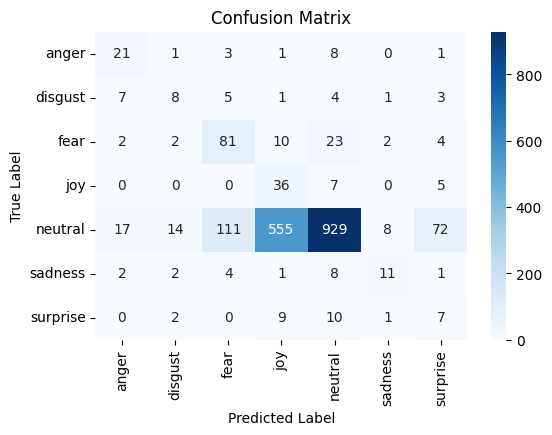

In [ ]:
conf_matrix = confusion_matrix(x, y, labels=labels)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
batch_1.columns

Index(['Unnamed: 0', 'date', 'title', 'source', 'number_of_characters_title',
       'number_of_words_title', 'day_of_week', 'month', 'year', 'quarter',
       'is_weekend', 'category', 'title1', 'Topic', 'broad_probs',
       'society_probs', 'prediction_set', 'probabilities', 'openAI_sentiment',
       'Unnamed: 0.1', 'title2', 'vader_sentiment', 'tb_polarity', 'tb_opnion',
       'afinn_score', 'flair_sentiment', 'flair_score', 'z-vader', 'z-afinn',
       'z-tb', 'roberta_score', 'roberta_score1', 'z-roberta', 'twrob_sent',
       'twrob_sent_label', 'openAI_emotion', 'emotion_label', 'emotion_score'],
      dtype='object')

In [ ]:
batch_1[(batch_1['emotion_label']=="neutral")&(batch_1['openAI_emotion']=="joy")]['title'].iloc[0]

'Intel Launches World’s First Systems Foundry Designed for the AI Era'

In [ ]:
batch_1[(batch_1['emotion_label']=="anger")&(batch_1['openAI_emotion']=="anger")]['title'].iloc[2]

'Salesforce’s Benioff delivers blistering wrap on Microsoft-Open AI accuracy, declares co-pilots the ‘next Clippy’ as reasoning, ‘autonomous agents’ create new business workforces'

In [ ]:
batch_1['emotion_label'].value_counts()

emotion_label
neutral     1706
fear         124
joy           48
anger         35
disgust       29
surprise      29
sadness       29
Name: count, dtype: int64

# fear analysis

Used a pretrained model - "Falconsai/fear_mongering_detection", to detect fear emotion in the headline(not the model is not finetuned to this data)

In [ ]:
df = pd.read_csv('datasets/all_sentiments_and_cat_pred_twrob_10k.csv')

In [ ]:
df.shape

(10000, 35)

In [ ]:
from transformers import pipeline

statement = "The rise of smart cities is part of a covert plan to create a global surveillance network, where every move and action is monitored and controlled."
classifier = pipeline("text-classification", model="Falconsai/fear_mongering_detection")
classifier(statement)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/709 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'Fear_Mongering', 'score': 1.0}]

In [ ]:
# Track progress using tqdm
from tqdm import tqdm
tqdm.pandas()

# Apply the classifier and store the results in a new column
df["fear_mongering_label"] = df["title"].progress_apply(lambda x: classifier(x)[0]["label"])
df["fear_mongering_score"] = df["title"].progress_apply(lambda x: classifier(x)[0]["score"])

100%|██████████| 10000/10000 [00:45<00:00, 217.41it/s]


In [ ]:
df[['title','fear_mongering_label','fear_mongering_score']]

title fear_mongering_label  \
0     will.i.am and Fyilicia on the AI revolution, i...   Non_Fear_Mongering   
1     Intel Launches World’s First Systems Foundry D...   Non_Fear_Mongering   
2        The Unique Challenges of Selling Enterprise AI   Non_Fear_Mongering   
3     Contentious California AI bill passes legislat...   Non_Fear_Mongering   
4     Exploring Genius, Creation, and Humanity in th...       Fear_Mongering   
...                                                 ...                  ...   
9995  EU Parliament approves landmark Artificial Int...   Non_Fear_Mongering   
9996  New study: UK should avoid EU-style AI regulat...   Non_Fear_Mongering   
9997  McKinsey and Google Cloud help companies tap i...   Non_Fear_Mongering   
9998  How AI Could Keep Young Workers From Getting t...       Fear_Mongering   
9999  SoftBank’s Masayoshi Son is reportedly seeking...   Non_Fear_Mongering   

      fear_mongering_score  
0                 0.999999  
1                 1.000000  
2                 1.000000  
3                 1.000000  
4                 1.000000  
...                    ...  
9995              1.000000  
9996              1.000000  
9997              1.000000  
9998              0.998434  
9999              0.999998  

[10000 rows x 3 columns]

In [ ]:
df['fear_mongering_label'].value_counts()

fear_mongering_label
Non_Fear_Mongering    6955
Fear_Mongering        3045
Name: count, dtype: int64

In [ ]:
df.to_csv('datasets/all_sentiments_and_cat_pred_twrob_fear_10k.csv')

In [ ]:
import ast
df['prediction_set'] = df['prediction_set'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
df['title1']

0       will i am and fyilicia on the ai revolution   ...
1       intel launches world   s first systems foundry...
2          the unique challenges of selling enterprise ai
3       contentious california ai bill passes legislat...
4       exploring genius   creation   and humanity in ...
                              ...                        
9995               eu parliament approves landmark ai act
9996    new study   uk should avoid eu style ai regula...
9997    mckinsey and google cloud help companies tap i...
9998    how ai could keep young workers from getting t...
9999    softbank   s masayoshi son is reportedly seeki...
Name: title1, Length: 10000, dtype: object

In [ ]:
df['title1'].fillna('',inplace =True)

# Using a pretrained sentiment model

Used a sentiment model which was pretrained on twitter data(which is short and human written so this model can give good result in our use case)

model- cardiffnlp/twitter-roberta-base-sentiment-latest

In [ ]:
import spacy


# Load spaCy model
nlp = spacy.load("en_core_web_sm")
# Function for lemmatization
def lemmatize_text_spacy(text):
    doc = nlp(text)
    return " ".join(token.lemma_ for token in doc)

# Enable progress tracking
tqdm.pandas()
# Apply to DataFrame column
df['title2'] = df['title1'].progress_apply(lemmatize_text_spacy)


100%|██████████| 10000/10000 [01:04<00:00, 154.46it/s]


In [ ]:
data = pd.read_csv("datasets/all_sentiments_and_cat_pred_10k.csv")
data.head(2)

Unnamed: 0        date                                              title  \
0           0  2024-10-14  will.i.am and Fyilicia on the AI revolution, i...   
1           1  2024-02-21  Intel Launches World’s First Systems Foundry D...   

                                           source  number_of_characters_title  \
0                                Evening Standard                         122   
1  Investor Relations :: Intel Corporation (INTC)                         117   

   number_of_words_title day_of_week     month  year  quarter  ...  tb_opnion  \
0                     20      Monday   October  2024        4  ...   0.000000   
1                     18   Wednesday  February  2024        1  ...   0.333333   

  afinn_score flair_sentiment  flair_score   z-vader   z-afinn      z-tb  \
0         0.0        NEGATIVE     0.794137 -0.307046 -0.183429 -0.252975   
1         0.0        POSITIVE     0.997875 -0.307046 -0.183429  0.994079   

  roberta_score roberta_score1  z-roberta  
0      0.246519       0.346619   0.974724  
1      0.336755       0.254922   0.675148  

[2 rows x 33 columns]

In [ ]:
from transformers import pipeline
import pandas as pd

In [ ]:
# download pre-trained tweet sentiment model
model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", device=0)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
from transformers import pipeline
from tqdm import tqdm

# Load the pre-trained sentiment model
model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", device=0)

# Convert text column to list
all_texts = data["title"].values.tolist()

# Define batch size (adjust based on memory and speed)
batch_size = 100
all_sentiments = []

# Process in batches and track progress
for i in tqdm(range(0, len(all_texts), batch_size), desc="Processing Sentiments"):
    batch = all_texts[i:i + batch_size]
    batch_sentiments = model(batch, truncation=True, max_length=512)
    all_sentiments.extend(batch_sentiments)  # Store results

# Add sentiments to DataFrame
data["twrob_sent"] = all_sentiments


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Processing Sentiments: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


In [ ]:
data['twrob_sent_label'] = data['twrob_sent'].apply(lambda x: x['label'])

In [ ]:
pd.crosstab(data['openAI_sentiment'],data['twrob_sent_label'])

twrob_sent_label  negative  neutral  positive
openAI_sentiment                             
Negative               674      731        20
Neutral                104     2908       119
Positive                31     3594      1819

In [ ]:
pd.crosstab(data['openAI_sentiment'],data['flair_sentiment'])

flair_sentiment   NEGATIVE  POSITIVE
openAI_sentiment                    
Negative               281        46
Neutral                419       392
Positive               355       990

In [ ]:
pd.crosstab(data['twrob_sent_label'],data['flair_sentiment'])

flair_sentiment   NEGATIVE  POSITIVE
twrob_sent_label                    
negative               170        23
neutral                790      1017
positive                95       388

In [ ]:
data.to_csv("datasets/all_sentiments_and_cat_pred_twrob_10k.csv", index=False)

# Data visualizations(same visualizations can be seen on Tableau)

In [ ]:
data =pd.read_csv("datasets/all_sentiments_and_cat_pred_twrob_10k.csv")

In [ ]:
c1 = data[(data['twrob_sent_label']=='negative')&(data['openAI_sentiment']=='Neutral')]
import plotly.express as px

custom_colors = {
    "Positive": "#32CD32",  # Medium green (LimeGreen)
    "Negative": "#FF6B6B",  # Medium red (Soft Coral)
    "Neutral": "#6495ED"    # Medium blue (Cornflower Blue)
}
fig = px.scatter(
    c1,
    x='vader_sentiment',
    y='roberta_score1',
    color='twrob_sent_label',         # Color by sentiment
    hover_data=['title'],             # Show 'title' on hover
    title='Interactive Sentiment Scatter Plot',
    color_discrete_map=custom_colors
)

# Update layout for better visuals
fig.update_layout(
    xaxis_title='VADER',
    yaxis_title='RoBERTa',
    legend_title='twrob_sent'
)

fig.show()
#fig.write_html("AI_newsheadlines_sentiment_plot.html")


In [ ]:
data[['title','twrob_sent']]

title  \
0     will.i.am and Fyilicia on the AI revolution, i...   
1     Intel Launches World’s First Systems Foundry D...   
2        The Unique Challenges of Selling Enterprise AI   
3     Contentious California AI bill passes legislat...   
4     Exploring Genius, Creation, and Humanity in th...   
...                                                 ...   
9995  EU Parliament approves landmark Artificial Int...   
9996  New study: UK should avoid EU-style AI regulat...   
9997  McKinsey and Google Cloud help companies tap i...   
9998  How AI Could Keep Young Workers From Getting t...   
9999  SoftBank’s Masayoshi Son is reportedly seeking...   

                                             twrob_sent  
0      {'label': 'neutral', 'score': 0.603238582611084}  
1     {'label': 'positive', 'score': 0.6290156841278...  
2      {'label': 'neutral', 'score': 0.777323305606842}  
3     {'label': 'positive', 'score': 0.8073647022247...  
4     {'label': 'positive', 'score': 0.741614818572998}  
...                                                 ...  
9995  {'label': 'neutral', 'score': 0.7755167484283447}  
9996  {'label': 'negative', 'score': 0.535753607749939}  
9997  {'label': 'positive', 'score': 0.6538031101226...  
9998  {'label': 'negative', 'score': 0.6659576296806...  
9999  {'label': 'neutral', 'score': 0.8253840208053589}  

[10000 rows x 2 columns]

In [ ]:
from sklearn.metrics import accuracy_score,classification_report


In [ ]:
r = classification_report(data['openAI_sentiment'].str.lower(),data['twrob_sent_label'])
print(r)

              precision    recall  f1-score   support

    negative       0.83      0.47      0.60      1425
     neutral       0.40      0.93      0.56      3131
    positive       0.93      0.33      0.49      5444

    accuracy                           0.54     10000
   macro avg       0.72      0.58      0.55     10000
weighted avg       0.75      0.54      0.53     10000



In [ ]:
data.columns

Index(['Unnamed: 0', 'date', 'title', 'source', 'number_of_characters_title',
       'number_of_words_title', 'day_of_week', 'month', 'year', 'quarter',
       'is_weekend', 'category', 'title1', 'Topic', 'broad_probs',
       'society_probs', 'prediction_set', 'probabilities', 'openAI_sentiment',
       'Unnamed: 0.1', 'title2', 'vader_sentiment', 'tb_polarity', 'tb_opnion',
       'afinn_score', 'flair_sentiment', 'flair_score', 'z-vader', 'z-afinn',
       'z-tb', 'roberta_score', 'roberta_score1', 'z-roberta', 'twrob_sent',
       'twrob_sent_label'],
      dtype='object')

In [ ]:
data['flair_sentiment'].value_counts()

flair_sentiment
POSITIVE    1428
NEGATIVE    1055
Name: count, dtype: int64

In [ ]:
import pandas as pd
import ast

# Example: Load the DataFrame (assuming it was saved and reloaded)


# Convert the string column back to dictionaries
data["twrob_sent"] = data["twrob_sent"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [ ]:
data['twrob_sent_score'] = data['twrob_sent'].apply(lambda x: x['score'])

<Axes: xlabel='twrob_sent_label', ylabel='twrob_sent_score'>

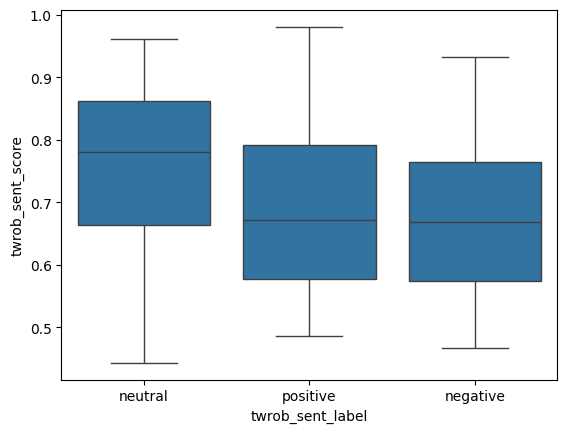

In [ ]:
sns.boxplot(x=data['twrob_sent_label'], y=data['twrob_sent_score'], data=data)

In [ ]:
pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech

# visualization
import plotly.express as px

In [ ]:
from bertopic import BERTopic

In [ ]:
topic_model = BERTopic.load("tmod2")

In [ ]:
topic_model.umap_model,topic_model.hdbscan_model,topic_model.vectorizer_model,topic_model.ctfidf_model

(UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=100, n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 HDBSCAN(min_cluster_size=20, prediction_data=True),
 CountVectorizer(min_df=2, ngram_range=(1, 2), stop_words='english'),
 ClassTfidfTransformer(reduce_frequent_words=True))

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
# download the sentence embeddings model
embedder = SentenceTransformer('all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
embedder1 = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
data['title2']

0       fyilicia ai revolution inclusivity voice uk te...
1       intel launch world first system foundry design...
2                  unique challenge selling enterprise ai
3       contentious california ai bill pass legislatur...
4               exploring genius creation humanity age ai
                              ...                        
9995               eu parliament approves landmark ai act
9996    new study uk avoid eu style ai regulation curr...
9997    mckinsey google cloud help company tap trillio...
9998        ai could keep young worker getting skill need
9999    softbank masayoshi son reportedly seeking b bu...
Name: title2, Length: 10000, dtype: object

In [ ]:
# embed article texts
corpus_embeddings = embedder.encode(data["title2"].values)
print(corpus_embeddings.shape)

(10000, 768)


In [ ]:
# embed article texts
corpus_embeddings1 = embedder1.encode(data["title2"].values)
print(corpus_embeddings1.shape)

(10000, 384)


In [ ]:
# reduce the size of the embeddings using UMAP
reduced_embeddings = UMAP(n_components=2, n_neighbors=100, min_dist=0.02).fit_transform(corpus_embeddings)
print(reduced_embeddings.shape)

# put the values of the two dimensions inside the dataframe
data["x"] = reduced_embeddings[:, 0]
data["y"] = reduced_embeddings[:, 1]

# substring of the full text, for visualization purposes


(10000, 2)


In [ ]:
# reduce the size of the embeddings using UMAP
reduced_embeddings1 = UMAP(n_components=2, n_neighbors=100, min_dist=0.02).fit_transform(corpus_embeddings1)
print(reduced_embeddings1.shape)

# put the values of the two dimensions inside the dataframe
data["x1"] = reduced_embeddings1[:, 0]
data["y1"] = reduced_embeddings1[:, 1]

(10000, 2)


In [ ]:
data.columns

Index(['Unnamed: 0', 'date', 'title', 'source', 'number_of_characters_title',
       'number_of_words_title', 'day_of_week', 'month', 'year', 'quarter',
       'is_weekend', 'category', 'title1', 'Topic', 'broad_probs',
       'society_probs', 'prediction_set', 'probabilities', 'openAI_sentiment',
       'Unnamed: 0.1', 'title2', 'vader_sentiment', 'tb_polarity', 'tb_opnion',
       'afinn_score', 'flair_sentiment', 'flair_score', 'z-vader', 'z-afinn',
       'z-tb', 'roberta_score', 'roberta_score1', 'z-roberta', 'twrob_sent',
       'twrob_sent_label', 'x', 'y'],
      dtype='object')

### 2d projection of the data points

In [ ]:
# scatter plot
hover_data = {
    "title": True,
    "x": False,
    "y": False
}
fig = px.scatter(data, x="x", y="y", color ="Topic",template="plotly_dark",
                   title="Embeddings", hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
# scatter plot
hover_data = {
    "title": True,
    "x1": False,
    "y1": False
}
fig = px.scatter(data, x="x1", y="y1", color ="Topic",template="plotly_dark",
                   title="Embeddings", hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
# scatter plot
hover_data = {
    "title": True,
    "x": False,
    "y": False
}
fig = px.scatter(data, x="x", y="y", color ="Topic",template="plotly_dark",
                   title="Embeddings", hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
data['prediction_set'].value_counts()[:10]

prediction_set
['{AI in various Industries}']                                       2078
['{AI in companies & Enterprises}']                                  1355
['{AI Governance & Geopolitics}']                                    1311
['{AI overview, risks & impact}']                                    1120
['{AI Investments & Market Trends}']                                  868
['{Education}']                                                       449
['{AI Ethics, Law & Policy}']                                         343
['{Careers & Workforce}']                                             226
['{AI in companies & Enterprises}', '{Other}']                        183
['{AI in various Industries}', '{AI in companies & Enterprises}']     116
Name: count, dtype: int64

In [ ]:
categories = ['{AI in various Industries}','{AI in companies & Enterprises}','{AI Governance & Geopolitics}','{AI overview, risks & impact}','{AI Investments & Market Trends}','{AI Ethics, Law & Policy}','{Education}','{Careers & Workforce}','{Other}']

for cat in categories:
  data[cat] = data['prediction_set'].apply(lambda x: cat in x)

In [ ]:
# scatter plot
hover_data = {
    "title": True,
    "x1": False,
    "y1": False
}
fig = px.scatter(data, x="x1", y="y1", color ="{AI in various Industries}",template="plotly_dark",
                   title="Embeddings", hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
c1

Empty DataFrame
Columns: [Unnamed: 0, date, title, source, number_of_characters_title, number_of_words_title, day_of_week, month, year, quarter, is_weekend, category, title1, Topic, broad_probs, society_probs, prediction_set, probabilities, openAI_sentiment, Unnamed: 0.1, title2, vader_sentiment, tb_polarity, tb_opnion, afinn_score, flair_sentiment, flair_score, z-vader, z-afinn, z-tb, roberta_score, roberta_score1, z-roberta, twrob_sent, twrob_sent_label, x, y, x1, y1, {AI in various Industries}, {AI in companies & Enterprises}, {AI Governance & Geopolitics}, {AI overview, risks & impact}, {AI Investments & Market Trends}, {AI Ethics, Law & Policy}, {Education}, {Careers & Workforce}, {Other}]
Index: []

[0 rows x 48 columns]

In [ ]:
data['prediction_set']

0                                             ['{Other}']
1                     ['{AI in companies & Enterprises}']
2       ['{AI in various Industries}', '{AI in compani...
3                       ['{AI Governance & Geopolitics}']
4                       ['{AI overview, risks & impact}']
                              ...                        
9995                    ['{AI Governance & Geopolitics}']
9996                    ['{AI Governance & Geopolitics}']
9997                  ['{AI in companies & Enterprises}']
9998                            ['{Careers & Workforce}']
9999                 ['{AI Investments & Market Trends}']
Name: prediction_set, Length: 10000, dtype: object

In [ ]:
data['prediction_set'].apply(lambda x:len(x)==1)

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: prediction_set, Length: 10000, dtype: bool

In [ ]:
c1

Empty DataFrame
Columns: [Unnamed: 0, date, title, source, number_of_characters_title, number_of_words_title, day_of_week, month, year, quarter, is_weekend, category, title1, Topic, broad_probs, society_probs, prediction_set, probabilities, openAI_sentiment, Unnamed: 0.1, title2, vader_sentiment, tb_polarity, tb_opnion, afinn_score, flair_sentiment, flair_score, z-vader, z-afinn, z-tb, roberta_score, roberta_score1, z-roberta, twrob_sent, twrob_sent_label, x, y, x1, y1, {AI in various Industries}, {AI in companies & Enterprises}, {AI Governance & Geopolitics}, {AI overview, risks & impact}, {AI Investments & Market Trends}, {AI Ethics, Law & Policy}, {Education}, {Careers & Workforce}, {Other}]
Index: []

[0 rows x 48 columns]

In [ ]:

import ast


data["pred_set1"] = data["prediction_set"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [ ]:
data['pred_set1'].iloc[0]

['{Other}']

In [ ]:
# scatter plot

cat = '{AI in various Industries}'
c1 = data[data['pred_set1'].apply(lambda x: x == [cat])]



hover_data = {
    "title": True,
    "x1": False,
    "y1": False
}
fig = px.scatter(c1, x="x1", y="y1", color = "Topic",template="plotly_dark",
                   title="Embeddings", hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
categories

['{AI in various Industries}',
 '{AI in companies & Enterprises}',
 '{AI Governance & Geopolitics}',
 '{AI overview, risks & impact}',
 '{AI Investments & Market Trends}',
 '{AI Ethics, Law & Policy}',
 '{Education}',
 '{Careers & Workforce}',
 '{Other}']

In [ ]:
# scatter plot

cat = '{AI in companies & Enterprises}'
c1 = data[data['pred_set1'].apply(lambda x: x == [cat])]



hover_data = {
    "title": True,
    "x1": False,
    "y1": False
}
fig = px.scatter(c1, x="x1", y="y1", color = "Topic",template="plotly_dark",
                   title="Embeddings", hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
# scatter plot

cat = '{AI Governance & Geopolitics}'
c1 = data[data['pred_set1'].apply(lambda x: x == [cat])]



hover_data = {
    "title": True,
    "x1": False,
    "y1": False
}
fig = px.scatter(c1, x="x1", y="y1", color = "Topic",template="plotly_dark",
                   title="Embeddings", hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
cat = '{AI overview, risks & impact}'
c1 = data[data['pred_set1'].apply(lambda x: x == [cat])]



hover_data = {
    "title": True,
    "x1": False,
    "y1": False
}
fig = px.scatter(c1, x="x1", y="y1", color = "Topic",template="plotly_dark",
                   title="Embeddings", hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
cat = categories[4]
c1 = data[data['pred_set1'].apply(lambda x: x == [cat])]



hover_data = {
    "title": True,
    "x1": False,
    "y1": False
}
fig = px.scatter(c1, x="x1", y="y1", color = "Topic",template="plotly_dark",
                   title="Embeddings for: "+cat, hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
# scatter plot

cat = categories[5]
c1 = data[data['pred_set1'].apply(lambda x: x == [cat])]



hover_data = {
    "title": True,
    "x1": False,
    "y1": False
}
fig = px.scatter(c1, x="x1", y="y1", color = "Topic",template="plotly_dark",
                   title="Embeddings for:"+cat, hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
# scatter plot

cat = categories[6]
c1 = data[data['pred_set1'].apply(lambda x: x == [cat])]



hover_data = {
    "title": True,
    "x1": False,
    "y1": False
}
fig = px.scatter(c1, x="x1", y="y1", color = "Topic",template="plotly_dark",
                   title="Embeddings for:"+cat, hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:

cat = categories[7]
c1 = data[data['pred_set1'].apply(lambda x: x == [cat])]



hover_data = {
    "title": True,
    "x1": False,
    "y1": False
}
fig = px.scatter(c1, x="x1", y="y1", color = "Topic",template="plotly_dark",
                   title="Embeddings for:"+cat, hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:

cat = categories[8]
c1 = data[data['pred_set1'].apply(lambda x: x == [cat])]



hover_data = {
    "title": True,
    "x1": False,
    "y1": False
}
fig = px.scatter(c1, x="x1", y="y1", color = "Topic",template="plotly_dark",
                   title="Embeddings for:"+cat, hover_data=hover_data)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
data.to_csv('datasets/embedding_data.csv')

In [ ]:
data = pd.read_csv('datasets/embedding_data.csv')

# Named entity recognition

Tried Named entity recognition not much information obtained

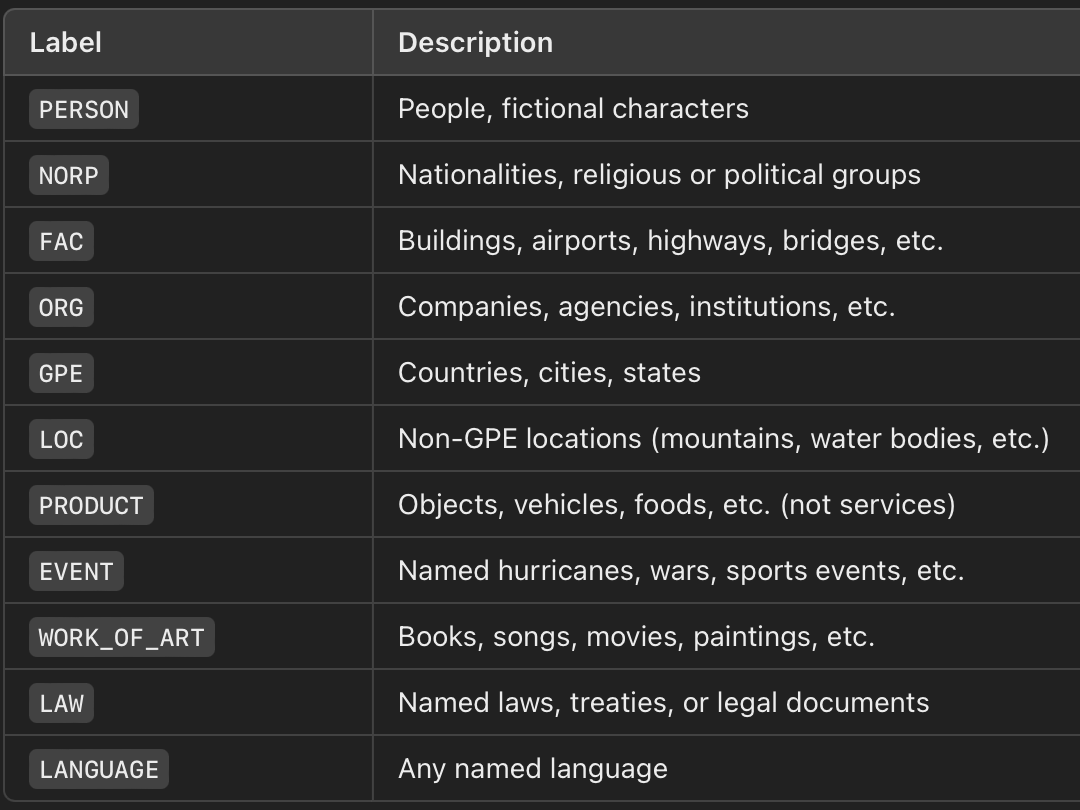

In [ ]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
text = "apple is looking at buying U.K startup at $1 dollars"
tokens = word_tokenize(text)
pos_tags = pos_tag(tokens)

entities = ne_chunk(pos_tags)
print(entities)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  apple/NN
  is/VBZ
  looking/VBG
  at/IN
  buying/VBG
  U.K/NNP
  startup/NN
  at/IN
  $/$
  1/CD
  dollars/NNS)


In [ ]:
data['title'].iloc[90]

'South Korea needs to accelerate renewable energy adoption to fuel Artificial Intelligence and semiconductor sectors'

In [ ]:
!pip install psycopg2-binary
!pip install feedparser
import pandas as pd
import numpy as np
from textblob import TextBlob
import feedparser
import requests
import json
import yaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 46.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.9 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=6d96aa23601fc3874b594157db6149271206772a38c909d862b51e2a718ea627
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k


In [ ]:
text = "South Korea needs to accelerate renewable energy adoption to fuel Artificial Intelligence and semiconductor sectors"

In [ ]:
#!pip install spacy

In [ ]:
import spacy
import pandas as pd

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Sample DataFrame
d = pd.DataFrame({
    'text': [
        "Apple is looking at buying a U.K. startup for $1 billion.",
        "Elon Musk founded SpaceX in 2002.",
        "Microsoft announced a new AI-powered search engine."
    ]
})

# Function to extract entities and group by labels
def extract_entities(text):
    doc = nlp(text)
    entity_dict = {}

    for ent in doc.ents:
        label = ent.label_
        entity_dict.setdefault(label, []).append(ent.text)  # Group by entity type

    return entity_dict

# Apply function to DataFrame
d['entities'] = d['text'].apply(extract_entities)

# Display results
print(d[['text', 'entities']])


                                                text  \
0  Apple is looking at buying a U.K. startup for ...   
1                  Elon Musk founded SpaceX in 2002.   
2  Microsoft announced a new AI-powered search en...   

                                            entities  
0  {'ORG': ['Apple'], 'GPE': ['U.K.'], 'MONEY': [...  
1        {'PERSON': ['Elon Musk'], 'DATE': ['2002']}  
2              {'ORG': ['Microsoft'], 'GPE': ['AI']}  


In [ ]:
d.head()

text  \
0  Apple is looking at buying a U.K. startup for ...   
1                  Elon Musk founded SpaceX in 2002.   
2  Microsoft announced a new AI-powered search en...   

                                            entities  
0  {'ORG': ['Apple'], 'GPE': ['U.K.'], 'MONEY': [...  
1        {'PERSON': ['Elon Musk'], 'DATE': ['2002']}  
2              {'ORG': ['Microsoft'], 'GPE': ['AI']}

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
data.columns

Index(['Unnamed: 0.2', 'Unnamed: 0', 'date', 'title', 'source',
       'number_of_characters_title', 'number_of_words_title', 'day_of_week',
       'month', 'year', 'quarter', 'is_weekend', 'category', 'title1', 'Topic',
       'broad_probs', 'society_probs', 'prediction_set', 'probabilities',
       'openAI_sentiment', 'Unnamed: 0.1', 'title2', 'vader_sentiment',
       'tb_polarity', 'tb_opnion', 'afinn_score', 'flair_sentiment',
       'flair_score', 'z-vader', 'z-afinn', 'z-tb', 'roberta_score',
       'roberta_score1', 'z-roberta', 'twrob_sent', 'twrob_sent_label', 'x',
       'y', 'x1', 'y1', '{AI in various Industries}',
       '{AI in companies & Enterprises}', '{AI Governance & Geopolitics}',
       '{AI overview, risks & impact}', '{AI Investments & Market Trends}',
       '{AI Ethics, Law & Policy}', '{Education}', '{Careers & Workforce}',
       '{Other}', 'pred_set1'],
      dtype='object')

In [ ]:
data1 = data[['Unnamed: 0','title','title1','title2']]

In [ ]:
print(nlp.get_pipe("ner").labels)

('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


In [ ]:
nlp.pipe_labels['ner']

['CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART']

In [ ]:
doc = nlp(text)
for ent in doc.ents:
    print(ent.text, "|",ent.label_, "|", spacy.explain(ent.label_))

South Korea | GPE | Countries, cities, states
Artificial Intelligence | ORG | Companies, agencies, institutions, etc.


In [ ]:
from spacy import displacy
displacy.render(doc,style="ent")

In [ ]:
text = "aws providing agile platforms for various startup at $1m dollars investment"
doc = nlp(text)
displacy.render(doc,style="ent")

In [ ]:
doc.ents

(apple, U.K, $1 dollars)

In [ ]:
data1 = data[['Unnamed: 0','title','title1','title2']]
data1['title3'] = data1['title'].str.lower()

<ipython-input-52-aee2111a5cf3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['title3'] = data1['title'].str.lower()


In [ ]:
data1.head()

Unnamed: 0                                              title  \
0           0  will.i.am and Fyilicia on the AI revolution, i...   
1           1  Intel Launches World’s First Systems Foundry D...   
2           2     The Unique Challenges of Selling Enterprise AI   
3           3  Contentious California AI bill passes legislat...   
4           4  Exploring Genius, Creation, and Humanity in th...   

                                              title1  \
0  will i am and fyilicia on the ai revolution   ...   
1  intel launches world   s first systems foundry...   
2     the unique challenges of selling enterprise ai   
3  contentious california ai bill passes legislat...   
4  exploring genius   creation   and humanity in ...   

                                              title2  \
0  fyilicia ai revolution inclusivity voice uk te...   
1  intel launch world first system foundry design...   
2             unique challenge selling enterprise ai   
3  contentious california ai bill pass legislatur...   
4          exploring genius creation humanity age ai   

                                              title3  
0  will.i.am and fyilicia on the ai revolution, i...  
1  intel launches world’s first systems foundry d...  
2     the unique challenges of selling enterprise ai  
3  contentious california ai bill passes legislat...  
4  exploring genius, creation, and humanity in th...

In [ ]:
import spacy
import pandas as pd

# Load spaCy model
nlp = spacy.load("en_core_web_sm")



# Get all entity labels from the spaCy model
entity_labels = nlp.get_pipe("ner").labels

# Initialize empty columns for all entity labels
for label in entity_labels:
    data1[label] = ""

# Function to extract entities and store in respective columns
def extract_entities(text):
    doc = nlp(text)
    entity_dict = {label: [] for label in entity_labels}  # Create an empty list for each entity type

    for ent in doc.ents:
        entity_dict[ent.label_].append(ent.text)  # Append entity to its corresponding label

    # Convert lists to comma-separated strings
    return {label: ", ".join(set(entity_dict[label])) for label in entity_labels}

# Apply the function to extract entities and store them in respective columns
entity_data = data1['title3'].apply(extract_entities).apply(pd.Series)

# Concatenate original data with entity columns
data1 = pd.concat([data1, entity_data], axis=1)

# Display the final DataFrame



<ipython-input-54-87056ee15d70>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[label] = ""
<ipython-input-54-87056ee15d70>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[label] = ""
<ipython-input-54-87056ee15d70>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

      Unnamed: 0.2  Unnamed: 0        date  \
0                0           0  2024-10-14   
1                1           1  2024-02-21   
2                2           2  2024-02-05   
3                3           3  2024-08-28   
4                4           4  2024-10-15   
...            ...         ...         ...   
9995          9995        9995  2024-03-13   
9996          9996        9996  2024-08-01   
9997          9997        9997  2024-04-04   
9998          9998        9998  2024-07-26   
9999          9999        9999  2024-02-19   

                                                  title  \
0     will.i.am and Fyilicia on the AI revolution, i...   
1     Intel Launches World’s First Systems Foundry D...   
2        The Unique Challenges of Selling Enterprise AI   
3     Contentious California AI bill passes legislat...   
4     Exploring Genius, Creation, and Humanity in th...   
...                                                 ...   
9995  EU Parliament approves landm

In [ ]:
data1.head()

Unnamed: 0                                              title  \
0           0  will.i.am and Fyilicia on the AI revolution, i...   
1           1  Intel Launches World’s First Systems Foundry D...   
2           2     The Unique Challenges of Selling Enterprise AI   
3           3  Contentious California AI bill passes legislat...   
4           4  Exploring Genius, Creation, and Humanity in th...   

                                              title1  \
0  will i am and fyilicia on the ai revolution   ...   
1  intel launches world   s first systems foundry...   
2     the unique challenges of selling enterprise ai   
3  contentious california ai bill passes legislat...   
4  exploring genius   creation   and humanity in ...   

                                              title2  \
0  fyilicia ai revolution inclusivity voice uk te...   
1  intel launch world first system foundry design...   
2             unique challenge selling enterprise ai   
3  contentious california ai bill pass legislatur...   
4          exploring genius creation humanity age ai   

                                              title3 CARDINAL DATE EVENT FAC  \
0  will.i.am and fyilicia on the ai revolution, i...                           
1  intel launches world’s first systems foundry d...                           
2     the unique challenges of selling enterprise ai                           
3  contentious california ai bill passes legislat...                           
4  exploring genius, creation, and humanity in th...                           

  GPE  ... MONEY NORP ORDINAL                         ORG PERCENT PERSON  \
0      ...                     uk ...tech & science daily                  
1      ...              first                       intel                  
2      ...                                                                 
3      ...                                                                 
4      ...                                                                 

  PRODUCT QUANTITY TIME WORK_OF_ART  
0                                    
1                                    
2                                    
3                                    
4                                    

[5 rows x 41 columns]

In [ ]:
data1['ORG']

ORG                         ORG
0         uk ...tech & science daily
1                              intel
2                                   
3                                   
4                                   
...   ..                         ...
9995                   eu parliament
9996                                
9997                                
9998                                
9999                                

[10000 rows x 2 columns]

In [ ]:
data1 = data[['Unnamed: 0','title','title1','title2']]
data1['title3'] = data1['title'].str.lower()

<ipython-input-70-b76c0fa2cff7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['title3'] = data1['title'].str.lower()


In [ ]:
import spacy
import pandas as pd

# Load spaCy model
nlp = spacy.load("en_core_web_sm")



# Get all entity labels from the spaCy model
entity_labels = nlp.get_pipe("ner").labels

# Function to extract entities and return lists
def extract_entities(text):
    doc = nlp(text)
    entity_dict = {label: [] for label in entity_labels}  # Initialize empty lists for each entity type

    for ent in doc.ents:
        if ent.text not in entity_dict[ent.label_]:  # Avoid duplicates
            entity_dict[ent.label_].append(ent.text)

    return entity_dict

# Apply the function to extract entities and store them in respective columns
entity_data1 = data1['title3'].apply(extract_entities).apply(pd.Series)

# Concatenate original data with entity columns
data1 = pd.concat([data1, entity_data1], axis=1)

# Display the final DataFrame
data1.head()


Unnamed: 0                                              title  \
0           0  will.i.am and Fyilicia on the AI revolution, i...   
1           1  Intel Launches World’s First Systems Foundry D...   
2           2     The Unique Challenges of Selling Enterprise AI   
3           3  Contentious California AI bill passes legislat...   
4           4  Exploring Genius, Creation, and Humanity in th...   

                                              title1  \
0  will i am and fyilicia on the ai revolution   ...   
1  intel launches world   s first systems foundry...   
2     the unique challenges of selling enterprise ai   
3  contentious california ai bill passes legislat...   
4  exploring genius   creation   and humanity in ...   

                                              title2  \
0  fyilicia ai revolution inclusivity voice uk te...   
1  intel launch world first system foundry design...   
2             unique challenge selling enterprise ai   
3  contentious california ai bill pass legislatur...   
4          exploring genius creation humanity age ai   

                                              title3 CARDINAL DATE EVENT FAC  \
0  will.i.am and fyilicia on the ai revolution, i...       []   []    []  []   
1  intel launches world’s first systems foundry d...       []   []    []  []   
2     the unique challenges of selling enterprise ai       []   []    []  []   
3  contentious california ai bill passes legislat...       []   []    []  []   
4  exploring genius, creation, and humanity in th...       []   []    []  []   

            GPE  ... MONEY NORP  ORDINAL                           ORG  \
0            []  ...    []   []       []  [uk ...tech & science daily]   
1            []  ...    []   []  [first]                       [intel]   
2            []  ...    []   []       []                            []   
3  [california]  ...    []   []       []                            []   
4            []  ...    []   []       []                            []   

  PERCENT PERSON PRODUCT QUANTITY TIME WORK_OF_ART  
0      []     []      []       []   []          []  
1      []     []      []       []   []          []  
2      []     []      []       []   []          []  
3      []     []      []       []   []          []  
4      []     []      []       []   []          []  

[5 rows x 23 columns]

In [ ]:
d.iloc[1]['ORG']

['Google', 'Apple']

In [ ]:
data1.to_csv('data-ner.csv')

In [ ]:
data1 = pd.read_csv('data-ner.csv')
data1.head()

Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                               title  \
0  will.i.am and Fyilicia on the AI revolution, i...   
1  Intel Launches World’s First Systems Foundry D...   
2     The Unique Challenges of Selling Enterprise AI   
3  Contentious California AI bill passes legislat...   
4  Exploring Genius, Creation, and Humanity in th...   

                                              title1  \
0  will i am and fyilicia on the ai revolution   ...   
1  intel launches world   s first systems foundry...   
2     the unique challenges of selling enterprise ai   
3  contentious california ai bill passes legislat...   
4  exploring genius   creation   and humanity in ...   

                                              title2  \
0  fyilicia ai revolution inclusivity voice uk te...   
1  intel launch world first system foundry design...   
2             unique challenge selling enterprise ai   
3  contentious california ai bill pass legislatur...   
4          exploring genius creation humanity age ai   

                                              title3 CARDINAL DATE EVENT FAC  \
0  will.i.am and fyilicia on the ai revolution, i...       []   []    []  []   
1  intel launches world’s first systems foundry d...       []   []    []  []   
2     the unique challenges of selling enterprise ai       []   []    []  []   
3  contentious california ai bill passes legislat...       []   []    []  []   
4  exploring genius, creation, and humanity in th...       []   []    []  []   

   ... MONEY NORP    ORDINAL                             ORG PERCENT PERSON  \
0  ...    []   []         []  ['uk ...tech & science daily']      []     []   
1  ...    []   []  ['first']                       ['intel']      []     []   
2  ...    []   []         []                              []      []     []   
3  ...    []   []         []                              []      []     []   
4  ...    []   []         []                              []      []     []   

  PRODUCT QUANTITY TIME WORK_OF_ART  
0      []       []   []          []  
1      []       []   []          []  
2      []       []   []          []  
3      []       []   []          []  
4      []       []   []          []  

[5 rows x 24 columns]

In [ ]:
import ast
data1["ORG"] = data1["ORG"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
import spacy
import pandas as pd
# Load spaCy model
nlp = spacy.load("en_core_web_sm")



# Get all entity labels from the spaCy model
entity_labels = nlp.get_pipe("ner").labels

In [ ]:
import ast
for l in entity_labels:
  data1[l] =data1[l].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [ ]:
data1.to_csv('data-ner1.csv')

In [ ]:
data1['ORG']

0       [uk ...tech & science daily]
1                            [intel]
2                                 []
3                                 []
4                                 []
                    ...             
9995                 [eu parliament]
9996                              []
9997                              []
9998                              []
9999                              []
Name: ORG, Length: 10000, dtype: object

669

In [ ]:
from collections import Counter

# Flatten the 'ORG' column into a single list of words
all_orgs = [org for org_list in data1['ORG'] for org in org_list]
orgs = set(all_orgs)
# Count the frequency of each word
word_freq = Counter(all_orgs)

# Convert the Counter object to a DataFrame to view the results
word_freq_df = pd.DataFrame(word_freq.items(), columns=["Organization", "Frequency"])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by="Frequency", ascending=False)

# Display the top 10 most frequent organizations
print(word_freq_df.head(10))


   Organization  Frequency
2        google        206
7     microsoft        180
16        apple         64
8           ibm         36
19      samsung         26
10       nvidia         25
1         intel         22
22         meta         20
69           un         19
15       amazon         18


In [ ]:
word_freq_df[word_freq_df['Frequency']>2].shape

(59, 2)

   Organization  Frequency
2        google        206
7     microsoft        180
16        apple         64
8           ibm         36
19      samsung         26
10       nvidia         25
1         intel         22
22         meta         20
69           un         19
15       amazon         18


Text(0.5, 1.0, 'Frequency of Organizations in Text Data')

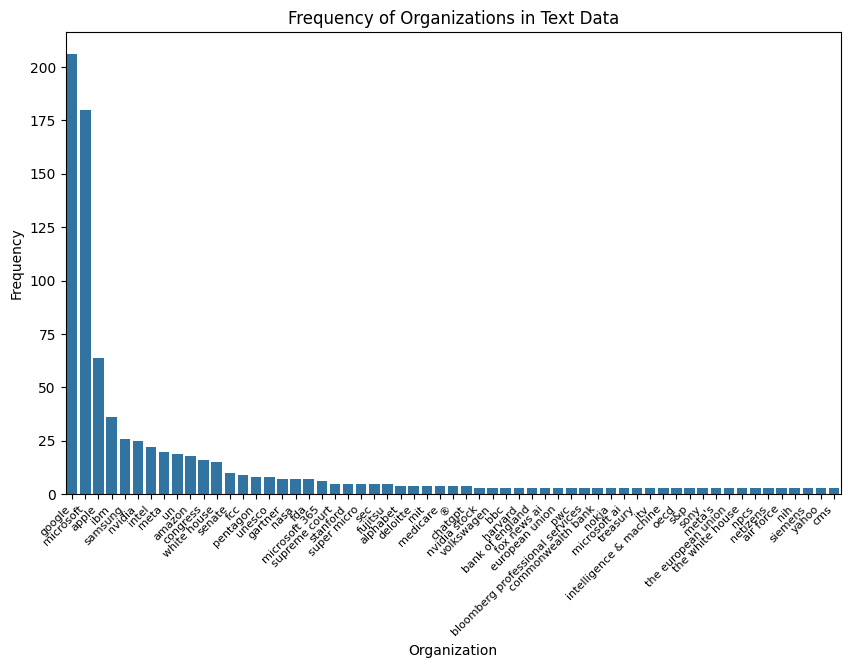

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Flatten the 'ORG' column into a single list of words
all_orgs = [org for org_list in data1['ORG'] for org in org_list]
orgs = set(all_orgs)
# Count the frequency of each word
word_freq = Counter(all_orgs)

# Convert the Counter object to a DataFrame to view the results
word_freq_df = pd.DataFrame(word_freq.items(), columns=["Organization", "Frequency"])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by="Frequency", ascending=False)

# Display the top 10 most frequent organizations
print(word_freq_df.head(10))

# Create the bar plot
plt.figure(figsize=(10, 6))  # Optional: Set figure size
sns.barplot(x="Organization", y="Frequency", data=word_freq_df[word_freq_df['Frequency']>2])

# Improve readability
plt.xticks(rotation=45, ha="right", fontsize=8)  # Rotate x-axis labels if needed
plt.xlabel("Organization")
plt.ylabel("Frequency")
plt.title("Frequency of Organizations in Text Data")


In [ ]:
['CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART']

       Country  Frequency
14       china         88
0   california         67
20          uk         58
4         u.s.         56
8         a.i.         45
9           us         36
3        india         36
2    australia         36
26      canada         24
37      israel         19


Text(0.5, 1.0, 'Frequency of Countries/cities/states in Text Data')

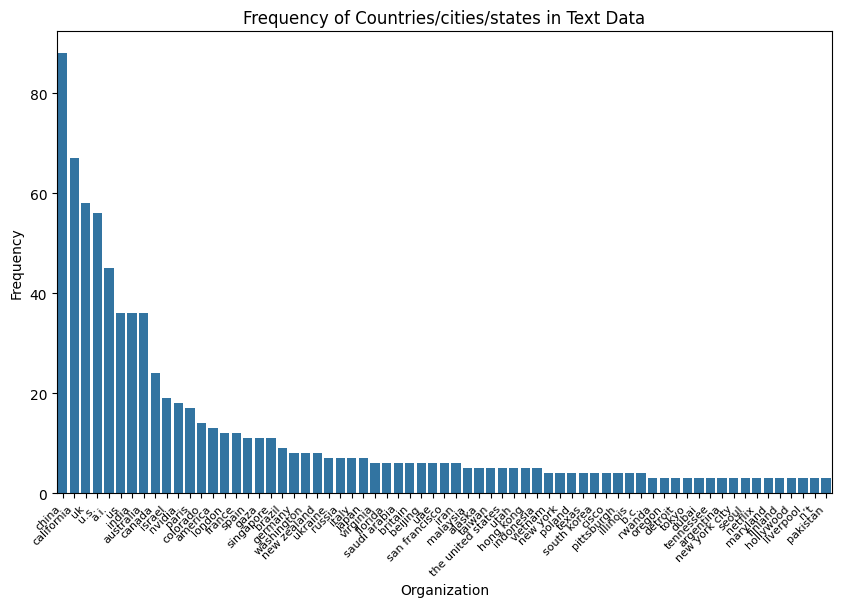

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Flatten the 'ORG' column into a single list of words
all_orgs = [org for org_list in data1['GPE'] for org in org_list]
orgs = set(all_orgs)
# Count the frequency of each word
word_freq = Counter(all_orgs)

# Convert the Counter object to a DataFrame to view the results
word_freq_df = pd.DataFrame(word_freq.items(), columns=["Country", "Frequency"])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by="Frequency", ascending=False)

# Display the top 10 most frequent organizations
print(word_freq_df.head(10))

# Create the bar plot
plt.figure(figsize=(10, 6))  # Optional: Set figure size
sns.barplot(x="Country", y="Frequency", data=word_freq_df[word_freq_df['Frequency']>2])

# Improve readability
plt.xticks(rotation=45, ha="right", fontsize=8)  # Rotate x-axis labels if needed
plt.xlabel("Organization")
plt.ylabel("Frequency")
plt.title("Frequency of Countries/cities/states in Text Data")


                   entity  Frequency
4                  europe         33
0                  africa         20
9                    asia          6
10          latin america          4
2          southeast asia          4
5          silicon valley          4
1            asia-pacific          3
20            middle east          3
23          north america          2
6   the geneva convention          1


Text(0.5, 1.0, 'Frequency of location in Text Data')

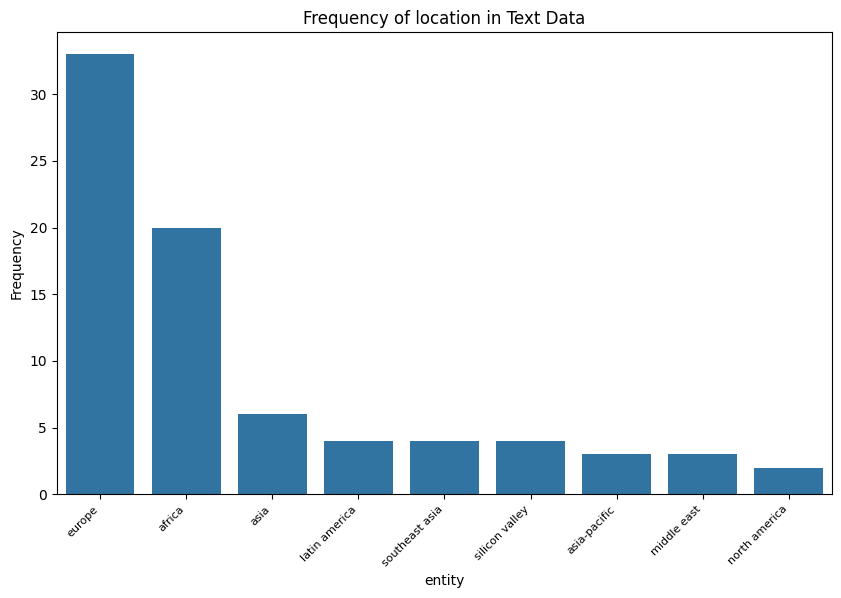

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Flatten the 'ORG' column into a single list of words
all_orgs = [org for org_list in data1['LOC'] for org in org_list]
orgs = set(all_orgs)
# Count the frequency of each word
word_freq = Counter(all_orgs)

# Convert the Counter object to a DataFrame to view the results
word_freq_df = pd.DataFrame(word_freq.items(), columns=["entity", "Frequency"])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by="Frequency", ascending=False)

# Display the top 10 most frequent organizations
print(word_freq_df.head(10))

# Create the bar plot
plt.figure(figsize=(10, 6))  # Optional: Set figure size
sns.barplot(x="entity", y="Frequency", data=word_freq_df[word_freq_df['Frequency']>1])

# Improve readability
plt.xticks(rotation=45, ha="right", fontsize=8)  # Rotate x-axis labels if needed
plt.xlabel("entity")
plt.ylabel("Frequency")
plt.title("Frequency of location in Text Data")


        entity  Frequency
6   australian         29
10     chinese         24
0     canadian         15
8     european         14
2       french         13
9    americans         11
16    american         10
3       indian         10
11     african          7
13     italian          7


Text(0.5, 1.0, 'Frequency of Nationality/regions/political groups in Text Data')

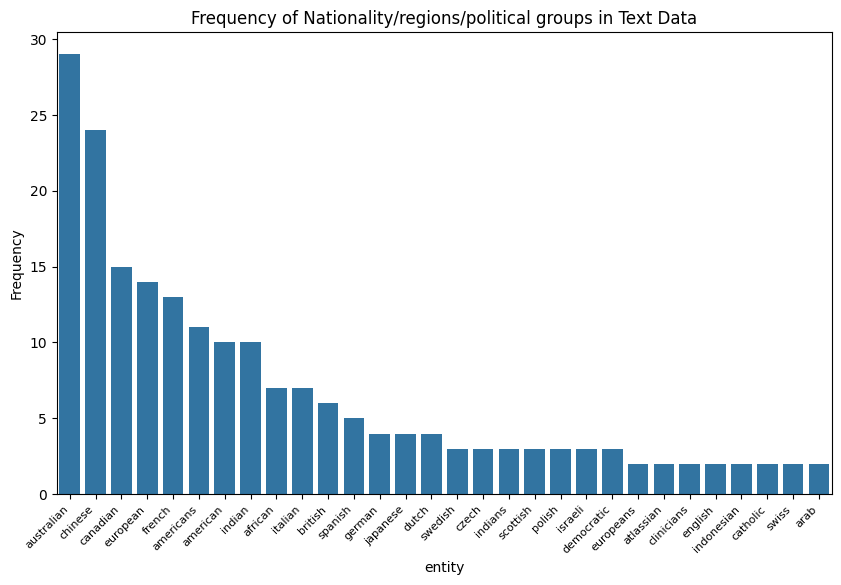

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Flatten the 'ORG' column into a single list of words
all_orgs = [org for org_list in data1['NORP'] for org in org_list]
orgs = set(all_orgs)
# Count the frequency of each word
word_freq = Counter(all_orgs)

# Convert the Counter object to a DataFrame to view the results
word_freq_df = pd.DataFrame(word_freq.items(), columns=["entity", "Frequency"])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by="Frequency", ascending=False)

# Display the top 10 most frequent organizations
print(word_freq_df.head(10))

# Create the bar plot
plt.figure(figsize=(10, 6))  # Optional: Set figure size
sns.barplot(x="entity", y="Frequency", data=word_freq_df[word_freq_df['Frequency']>1])

# Improve readability
plt.xticks(rotation=45, ha="right", fontsize=8)  # Rotate x-axis labels if needed
plt.xlabel("entity")
plt.ylabel("Frequency")
plt.title("Frequency of Nationality/regions/political groups in Text Data")


              entity  Frequency
1             google         16
0        vandi verma          1
2  google apologizes          1
3           b200 gpu          1
4           explores          1
5                 ’s          1
6      the eu ai act          1
7    the eu ai act’s          1
8           ole miss          1
9               700k          1


Text(0.5, 1.0, 'Frequency of Nationality/regions/political groups in Text Data')

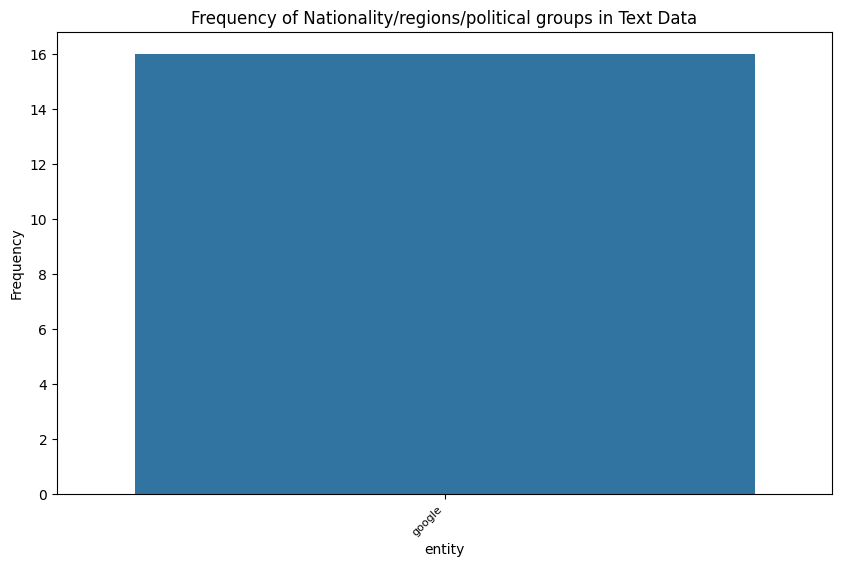

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Flatten the 'ORG' column into a single list of words
all_orgs = [org for org_list in data1['PRODUCT'] for org in org_list]
orgs = set(all_orgs)
# Count the frequency of each word
word_freq = Counter(all_orgs)

# Convert the Counter object to a DataFrame to view the results
word_freq_df = pd.DataFrame(word_freq.items(), columns=["entity", "Frequency"])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by="Frequency", ascending=False)

# Display the top 10 most frequent organizations
print(word_freq_df.head(10))

# Create the bar plot
plt.figure(figsize=(10, 6))  # Optional: Set figure size
sns.barplot(x="entity", y="Frequency", data=word_freq_df[word_freq_df['Frequency']>1])

# Improve readability
plt.xticks(rotation=45, ha="right", fontsize=8)  # Rotate x-axis labels if needed
plt.xlabel("entity")
plt.ylabel("Frequency")
plt.title("Frequency of Nationality/regions/political groups in Text Data")
